<a href="https://colab.research.google.com/github/alanmtz2/FastAPI-crud/blob/main/geospacial_res_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx geopandas matplotlib folium


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 794.3 kB/s eta 0:00:00


In [ ]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# Configurar el nombre de la ciudad y el tipo de POI
city_name = "Ciudad de México, Mexico"
poi_type = 'restaurant'

# Descargar POIs desde OpenStreetMap
gdf_poi = ox.geometries_from_place(city_name, tags={'amenity': poi_type})

# Descargar la red de calles de la ciudad
gdf_streets = ox.graph_from_place(city_name, network_type='drive')
gdf_streets = ox.graph_to_gdfs(gdf_streets, nodes=False, edges=True)

print("Datos de POI y red de calles descargados.")


<ipython-input-2-b9b40e48aad3>:10: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_poi = ox.geometries_from_place(city_name, tags={'amenity': poi_type})


Datos de POI y red de calles descargados.


In [ ]:
# Asegurar que los datos de POI y calles están en el mismo CRS
gdf_poi = gdf_poi.set_crs(epsg=4326)
gdf_streets = gdf_streets.set_crs(epsg=4326)

# Filtrar columnas relevantes
gdf_poi = gdf_poi[['name', 'geometry']]


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


                                   name                    geometry
element_type osmid                                                 
node         293208350             Toks  POINT (-99.17230 19.34531)
             318084624  Sanborns Loreto  POINT (-99.19286 19.33875)
             319147480         Sanborns  POINT (-99.18802 19.34704)
             326552536             Toks  POINT (-99.17929 19.37407)
             331418533      La Estación  POINT (-99.19095 19.38852)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


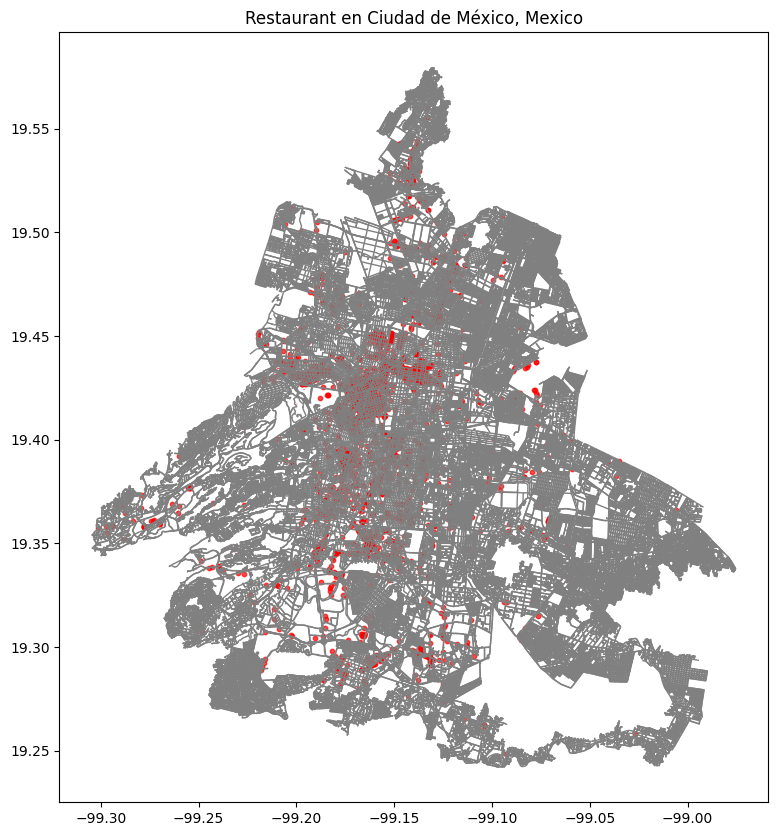

In [ ]:
# Mostrar los primeros registros de POI
print(gdf_poi.head())

# Plotear los POI y la red de calles
fig, ax = plt.subplots(figsize=(10, 10))
gdf_streets.plot(ax=ax, linewidth=1, edgecolor='gray')
gdf_poi.plot(ax=ax, color='red', markersize=10, alpha=0.7)
plt.title(f'{poi_type.capitalize()} en {city_name}')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


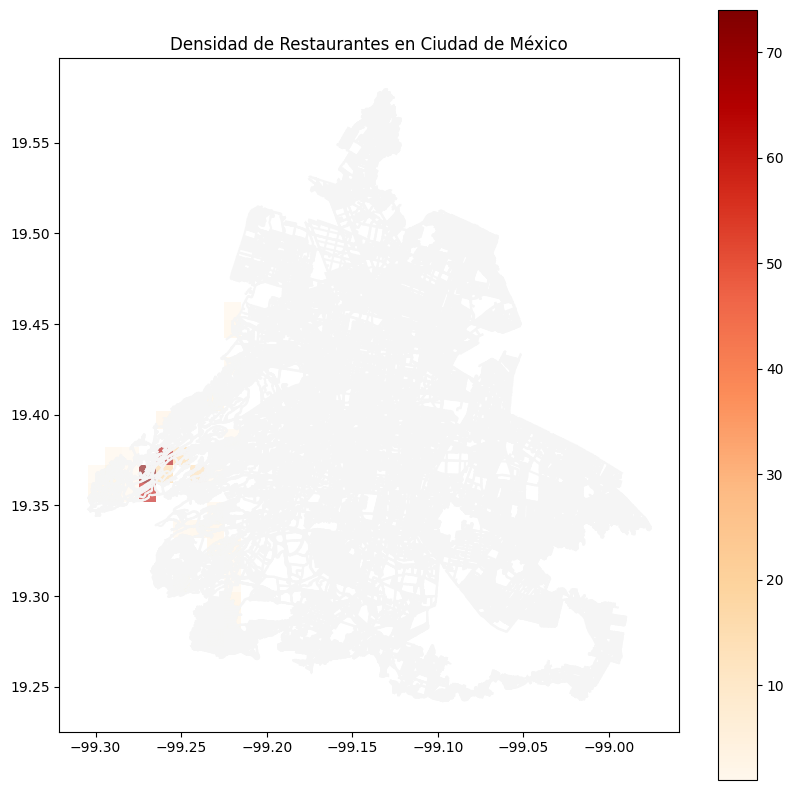

In [ ]:
import numpy as np
from shapely.geometry import Polygon, Point
from geopandas.tools import sjoin

# Crear una cuadrícula de celdas para análisis de densidad
xmin, ymin, xmax, ymax = gdf_streets.total_bounds
cell_size = 0.01  # Ajustar el tamaño de celda según la resolución deseada
grid_cells = []
for x in np.arange(xmin, xmax, cell_size):
    for y in np.arange(ymin, ymax, cell_size):
        grid_cells.append(Polygon([(x, y), (x+cell_size, y), (x+cell_size, y+cell_size), (x, y+cell_size)]))
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf_streets.crs)

# Unir POI con la cuadrícula
poi_density = sjoin(gdf_poi, grid, how='left', op='within')
poi_density = poi_density.groupby('index_right').size().reset_index(name='poi_count')
grid.loc[poi_density['index_right'], 'poi_count'] = poi_density['poi_count']

# Plotear el mapa de densidad
fig, ax = plt.subplots(figsize=(10, 10))
gdf_streets.plot(ax=ax, color='whitesmoke', edgecolor='black')
grid.plot(column='poi_count', ax=ax, cmap='OrRd', legend=True, alpha=0.6)
plt.title('Densidad de Restaurantes en Ciudad de México')
plt.show()


In [ ]:
import folium

# Crear un mapa de Folium centrado en la Ciudad de México
m = folium.Map(location=[gdf_streets.geometry.centroid.y.mean(), gdf_streets.geometry.centroid.x.mean()], zoom_start=12)

# Añadir POI al mapa
for _, row in gdf_poi.iterrows():
    if isinstance(row.geometry, Point):
        folium.Marker([row.geometry.y, row.geometry.x], popup=row['name']).add_to(m)

# Añadir la densidad de POI al mapa usando los centroides de la cuadrícula
for _, row in grid.iterrows():
    if 'poi_count' in row and row['poi_count'] > 0:
        folium.CircleMarker(
            location=[row.geometry.centroid.y, row.geometry.centroid.x],
            radius=5,
            popup=f"Densidad: {row['poi_count']}",
            color='crimson',
            fill=True,
            fill_color='crimson'
        ).add_to(m)

# Guardar el mapa
m.save('poi_map.html')
print("Mapa interactivo guardado como 'poi_map.html'.")



<ipython-input-9-89339e15a54e>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf_streets.geometry.centroid.y.mean(), gdf_streets.geometry.centroid.x.mean()], zoom_start=12)


Mapa interactivo guardado como 'poi_map.html'.
